# Predict the error of Zestimates using advanced regression methods

## Wenqian Li, Tongke Wu

### STA208 Final Project 2017 Spring Quarter

## Introduction

The Zestimate home value is Zillow's estimated market value for an individual home and is calculated for about 100 million homes nationwide. Buying or selling a home is usually the largest transaction in one's lifetime, so it is critical for Zillow to give consumers a trusted estimate. This will not only increase the popularities of Zillow among consumers but also keep Zillow away from lawsuit for undervaluing their house [Zillow faces lawsuit over Zestimate tool](https://www.washingtonpost.com/realestate/zillow-faces-lawsuit-over-zestimate-tool-that-calculates-a-houses-worth/2017/05/09/b22d0318-3410-11e7-b4ee-434b6d506b37_story.html?utm_term=.4870d57f4a6a). 

In this project, we will use the dataset released by a featured prediction kaggle [compitition](https://www.kaggle.com/c/zillow-prize-1). Different with common real estate project, this dataset does not reveal the exact saleprice. Instead, it uses \textit{logerror} as response variable, where $$logerror = log(Zestimate) - log(SalePrice)$$ 

The dataset provides 57 features, in which 52 are numerical features and 5 are object features. Out of the numerical features, a number of them actually should belong to object/categorical features, such as airconditioningtypeid, architecturalstyletypeid, and etc. In these features, different types do not convey ordered information. 



2985217 of property information is provided, but only 90811 of them have been sold in 2016 and have logerror information. With these 90811 samples, 80% data points are used as training data and the rest 20% samples are used as testing data. We plan to fit different regression models and find a model that gives the minimum MSE for testing data.

One challenge of this dataset is that, there are lots of missing values in many variables. We adopted several methods to solve this issue. First, if the missing values in one categorical variable clearly indicate one category, replace it with the guessed category. If not clear, replace it with Unknown. Second, if the missing values in one numerical variable clearly indicate 0, replace it with 0. If not clear, then replace it with -1 and add a new categorical feature indicating whether the former variable is known or unknown with 1 or 0. Third, if a small proportional of values are missing, replace them with the mean. 

### Feature engineering: cluster for geographical features

Another challenge of this dataset is that, there are quite a number of geographical features that are not easy to deal with. For categorical ones, there may be thousands of possible categories for one feature, making is impossible to get dummy variables or run random forest algorithm directly. For numerical ones, the numbers are not really carrying ordered information, such as zipcode, latitude and longitude.

To solve this puzzle, we selected several geographical features from dataset, including FIPS, Latitude, Longitude, Raw_census, City, County, Neighbourhood, and Zipcode. We first vectorized these features and performed Kmeans clustering to get 8 clusters for geographical information. Then we dropped the original geographical features and merged the geographical clusters in the training dataset. Overall, we get a trimmed dataset with 100 features after getting dummy variables for the categorical features.

## Methods

For each method, we first tune the parameters to minimize MSE, then fit models with selected parameters. 

1. Linear Regression

2. Ridge Regression

3. Lasso Regression

4. Linear SVM Regression

4. Random Forest Regression

5. Adaboost Regression

6. Xgboost Regression

In [1]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(color_codes=True)
import numpy as np

properties_2016.csv stores the information of 2985217 homes.

In [4]:
properties_2016 = pd.read_csv("properties_2016.csv")
properties_2016.describe()
#53 columns are numerical

/Users/wenqian/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,parcelid,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,buildingqualitytypeid,calculatedbathnbr,decktypeid,...,yardbuildingsqft26,yearbuilt,numberofstories,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock
count,2.985217e+06,811519.000000,6061.000000,1628.000000,2.973755e+06,2.973767e+06,12629.000000,1.938488e+06,2.856305e+06,17096.0,...,2647.000000,2.925289e+06,682069.000000,2.930235e+06,2.942667e+06,2.973778e+06,2.917484e+06,2.953967e+06,56464.000000,2.910091e+06
mean,1.332586e+07,1.931166,7.202607,646.883292,2.209143e+00,3.088949e+00,3.725948,5.784787e+00,2.299263e+00,66.0,...,278.296562,1.964262e+03,1.401464,1.708836e+05,4.204790e+05,2.014999e+03,2.524780e+05,5.377607e+03,13.892409,6.048431e+13
std,7.909966e+06,3.148587,2.436290,538.793473,1.077754e+00,1.275859e+00,0.501700,1.805352e+00,1.000736e+00,0.0,...,369.731508,2.344132e+01,0.539076,4.020683e+05,7.263467e+05,3.683161e-02,4.450132e+05,9.183107e+03,2.581006,3.249035e+11
min,1.071172e+07,1.000000,2.000000,20.000000,0.000000e+00,0.000000e+00,1.000000,1.000000e+00,1.000000e+00,66.0,...,10.000000,1.801000e+03,1.000000,1.000000e+00,1.000000e+00,2.000000e+03,1.000000e+00,1.340000e+00,0.000000,-1.000000e+00
25%,1.164371e+07,1.000000,7.000000,272.000000,2.000000e+00,2.000000e+00,3.000000,4.000000e+00,2.000000e+00,66.0,...,96.000000,1.950000e+03,1.000000,7.480000e+04,1.796750e+05,2.015000e+03,7.483600e+04,2.461070e+03,14.000000,6.037400e+13
50%,1.254509e+07,1.000000,7.000000,534.000000,2.000000e+00,3.000000e+00,4.000000,7.000000e+00,2.000000e+00,66.0,...,168.000000,1.963000e+03,1.000000,1.225900e+05,3.060860e+05,2.015000e+03,1.670420e+05,3.991780e+03,14.000000,6.037572e+13
75%,1.409712e+07,1.000000,7.000000,847.250000,3.000000e+00,4.000000e+00,4.000000,7.000000e+00,3.000000e+00,66.0,...,320.000000,1.981000e+03,2.000000,1.968890e+05,4.880000e+05,2.015000e+03,3.069180e+05,6.201005e+03,15.000000,6.059042e+13
max,1.696019e+08,13.000000,27.000000,8516.000000,2.000000e+01,2.000000e+01,5.000000,1.200000e+01,2.000000e+01,66.0,...,6141.000000,2.015000e+03,41.000000,2.514860e+08,2.827860e+08,2.016000e+03,9.024622e+07,3.458861e+06,99.000000,4.830301e+14


In [6]:
properties_2016.shape

(2985217, 58)

In [8]:
#numerical variable include
num_val = properties_2016.select_dtypes(include = ['float64','int64']).columns
num_val #53

Index([u'parcelid', u'airconditioningtypeid', u'architecturalstyletypeid',
       u'basementsqft', u'bathroomcnt', u'bedroomcnt', u'buildingclasstypeid',
       u'buildingqualitytypeid', u'calculatedbathnbr', u'decktypeid',
       u'finishedfloor1squarefeet', u'calculatedfinishedsquarefeet',
       u'finishedsquarefeet12', u'finishedsquarefeet13',
       u'finishedsquarefeet15', u'finishedsquarefeet50',
       u'finishedsquarefeet6', u'fips', u'fireplacecnt', u'fullbathcnt',
       u'garagecarcnt', u'garagetotalsqft', u'heatingorsystemtypeid',
       u'latitude', u'longitude', u'lotsizesquarefeet', u'poolcnt',
       u'poolsizesum', u'pooltypeid10', u'pooltypeid2', u'pooltypeid7',
       u'propertylandusetypeid', u'rawcensustractandblock', u'regionidcity',
       u'regionidcounty', u'regionidneighborhood', u'regionidzip', u'roomcnt',
       u'storytypeid', u'threequarterbathnbr', u'typeconstructiontypeid',
       u'unitcnt', u'yardbuildingsqft17', u'yardbuildingsqft26', u'yearbuilt',
 

In [9]:
#categorical variable include
cat_val = properties_2016.select_dtypes(include = ['object']).columns
#len is 5
cat_val

Index([u'hashottuborspa', u'propertycountylandusecode', u'propertyzoningdesc',
       u'fireplaceflag', u'taxdelinquencyflag'],
      dtype='object')

In [11]:
#Read in the train data
train_2016 = pd.read_csv("train_2016.csv")

In [12]:
#train_prop is the merged dataset
train_prop = train_2016.merge(properties_2016, how = "inner", on = "parcelid")
train_prop.shape

(90811, 60)

In [13]:
train_prop.to_csv("train_prop.csv")

## There are quite a number of missing values in many features.

In [14]:
#There are quite a number of missing values in many features.
na_train = train_prop.isnull().sum()
na_train

parcelid                            0
logerror                            0
transactiondate                     0
airconditioningtypeid           62030
architecturalstyletypeid        90550
basementsqft                    90768
bathroomcnt                       536
bedroomcnt                        536
buildingclasstypeid             90795
buildingqualitytypeid           33447
calculatedbathnbr                1718
decktypeid                      90153
finishedfloor1squarefeet        83955
calculatedfinishedsquarefeet     1197
finishedsquarefeet12             5215
finishedsquarefeet13            90778
finishedsquarefeet15            87247
finishedsquarefeet50            83955
finishedsquarefeet6             90390
fips                              536
fireplacecnt                    81204
fullbathcnt                      1718
garagecarcnt                    60874
garagetotalsqft                 60874
hashottuborspa                  88446
heatingorsystemtypeid           34731
latitude    

### To rename the features for better representation.

In [16]:
colrename = {
            "parcelid":"Parcel_ID",
            "transactiondate": "tran_date", 
            "airconditioningtypeid":"AC_Type",
            "architecturalstyletypeid":"Arch_Type",
            "basementsqft":"Basement_Area",
            "bathroomcnt":"Bath_Count",
            "bedroomcnt":"Bed_Count",
            "buildingclasstypeid":"Frame_Type",
            "buildingqualitytypeid":"Quality_Level",
            "calculatedbathnbr":"Bed_with_bath_Count",
            "decktypeid":"Deck_Type",
            "finishedfloor1squarefeet":"First_calculated_Area",
            "calculatedfinishedsquarefeet":"Total_living_Area",
            "finishedsquarefeet12":"Finished_living_Area",
            "finishedsquarefeet13":"Perimeter_living_Area",
            "finishedsquarefeet15":"Total_Area",
            "finishedsquarefeet50":"First_Area",
            "finishedsquarefeet6":"Base_total_Area",
            "fips":"FIPS",
            "fireplacecnt":"FirePlace_Count", 
            "fullbathcnt":"Bath_full_Count", 
            "garagecarcnt":"Garage_Count", 
            "garagetotalsqft":"Garage_Area",
            "hashottuborspa":"Tub_Spa_Type", 
            "heatingorsystemtypeid":"Heat_Type", 
            "latitude":"Latitude", 
            "longitude":"Longitude",
            "lotsizesquarefeet":"Lot_Area", 
            "poolcnt":"Pool_Count", 
            "poolsizesum":"Pool_Area", 
            "pooltypeid10":"Spa_Tub",
            "pooltypeid2":"Pool_with_Spa_Tub", 
            "pooltypeid7":"Pool_wo_Spa_Tub", 
            "propertycountylandusecode":"Land_Code",
            "propertylandusetypeid":"Land_Type", 
            "propertyzoningdesc":"Zone_desc",
            "rawcensustractandblock":"Raw_census", 
            "regionidcity":"City", 
            "regionidcounty":"County",
            "regionidneighborhood":"Neighborhood", 
            "regionidzip":"Zipcode", 
            "roomcnt":"Room_Count", 
            "storytypeid":"Floor_Type",
            "threequarterbathnbr":"Bath_partial_Count", 
            "typeconstructiontypeid":"Material_Type", 
            "unitcnt":"Unit_Count",
            "yardbuildingsqft17":"Patio_yard_Area", 
            "yardbuildingsqft26":"Storage_yard_Area", 
            "yearbuilt":"Year",
            "numberofstories":"Story_Count", 
            "fireplaceflag":"Fireplace_YN", 
            "structuretaxvaluedollarcnt":"Tax_structure_Value",
            "taxvaluedollarcnt":"Tax_total_Value", 
            "assessmentyear":"Tax_assess_Year", 
            "landtaxvaluedollarcnt":"Taxable_land_Value",
            "taxamount":"Tax_Amount", 
            "taxdelinquencyflag":"Tax_delinq_YN", 
            "taxdelinquencyyear":"Tax_delinq_Year",
            "censustractandblock":"Census"}

In [17]:
train_data = train_prop.rename(columns = colrename)

In [18]:
train_data = train_data.set_index("Parcel_ID")

In [19]:
train_data.to_csv("renamed_train.csv")

In [20]:
train_data.head()

,logerror,tran_date,AC_Type,Arch_Type,Basement_Area,Bath_Count,Bed_Count,Frame_Type,Quality_Level,Bed_with_bath_Count,...,Story_Count,Fireplace_YN,Tax_structure_Value,Tax_total_Value,Tax_assess_Year,Taxable_land_Value,Tax_Amount,Tax_delinq_YN,Tax_delinq_Year,Census
Parcel_ID,,,,,,,,,,,,,,,,,,,,,
11016594,0.0276,2016-01-01,1.0,NaN,NaN,2.0,3.0,NaN,4.0,2.0,...,NaN,NaN,122754.0,360170.0,2015.0,237416.0,6735.88,NaN,NaN,6.037107e+13
14366692,-0.1684,2016-01-01,NaN,NaN,NaN,3.5,4.0,NaN,NaN,3.5,...,NaN,NaN,346458.0,585529.0,2015.0,239071.0,10153.02,NaN,NaN,NaN
12098116,-0.0040,2016-01-01,1.0,NaN,NaN,3.0,2.0,NaN,4.0,3.0,...,NaN,NaN,61994.0,119906.0,2015.0,57912.0,11484.48,NaN,NaN,6.037464e+13
12643413,0.0218,2016-01-02,1.0,NaN,NaN,2.0,2.0,NaN,4.0,2.0,...,NaN,NaN,171518.0,244880.0,2015.0,73362.0,3048.74,NaN,NaN,6.037296e+13
14432541,-0.0050,2016-01-02,NaN,NaN,NaN,2.5,4.0,NaN,NaN,2.5,...,2.0,NaN,169574.0,434551.0,2015.0,264977.0,5488.96,NaN,NaN,6.059042e+13


In [21]:
train_data.shape

(90811, 59)

### Get the distributions of missing values cross rows.

In [22]:
train_data.isnull().sum(axis = 1).sort_values()
#Maximum has 57 NA values, meaning there is no info for these houses at all

Parcel_ID
17292779    19
17126214    19
17192948    20
17193859    20
17207897    20
17054540    20
17267191    20
17192980    20
17060684    20
17192968    20
17194510    20
17097120    20
17238411    20
17194545    20
17071030    20
17292778    20
17144606    21
17193148    21
17226347    21
17266177    21
17194613    21
17194515    21
17271039    21
17266100    21
17288786    21
17075921    21
17209571    21
17290532    21
17268019    21
17267315    21
            ..
11955576    57
14240136    57
17112936    57
14341030    57
14325564    57
14068860    57
12956255    57
17205130    57
14455418    57
14325541    57
14367642    57
14285166    57
14285220    57
17112973    57
12768362    57
12768366    57
13027302    57
14341960    57
11795571    57
17112821    57
17112255    57
11970599    57
11494656    57
17112821    57
14366754    57
14341195    57
14367623    57
17205215    57
17112281    57
11877012    57
Length: 90811, dtype: int64

In [23]:
row_nan = Counter(train_data.isnull().sum(axis = 1))
#There are 536 houses without any info. This may be interesting but we think it is better to eliminate at this point

In [24]:
row_nan = pd.DataFrame(row_nan.items(), columns = ["nan","count"])

In [25]:
row_nan #The distribution of number of nan in each row

,nan,count
0,19,2
1,20,14
2,21,79
3,22,271
4,23,585
5,24,713
6,25,6570
7,26,8857
8,27,13942
9,28,23669


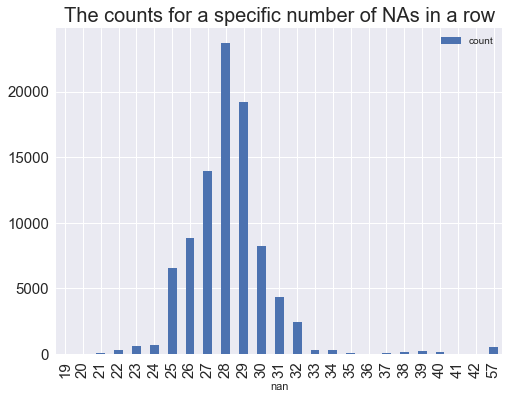

In [26]:
ax = row_nan.plot.bar(x = 'nan', y = 'count', figsize = (8,6), fontsize = 15)
ax.set_title("The counts for a specific number of NAs in a row", fontsize = 20)

In [27]:
#The rows with all nan
train_nan = train_data[train_data.isnull().sum(axis = 1) == 57]
train_nan.shape

(536, 59)

### Remove the rows with 57 Nan values, all the features are missing.

In [28]:
#remove the rows with 57 nan values
train = train_data[train_data.isnull().sum(axis = 1) != 57]
train.shape

(90275, 59)

In [30]:
train.to_csv("train.csv")

## Read in raw train data with missing values and Deal with missing values.

In [2]:
train = pd.read_csv("train.csv")

In [3]:
#numerical variable include
train.select_dtypes(include = ['float64','int64']).columns

Index([u'Parcel_ID', u'logerror', u'AC_Type', u'Arch_Type', u'Basement_Area',
       u'Bath_Count', u'Bed_Count', u'Frame_Type', u'Quality_Level',
       u'Bed_with_bath_Count', u'Deck_Type', u'First_calculated_Area',
       u'Total_living_Area', u'Finished_living_Area', u'Perimeter_living_Area',
       u'Total_Area', u'First_Area', u'Base_total_Area', u'FIPS',
       u'FirePlace_Count', u'Bath_full_Count', u'Garage_Count', u'Garage_Area',
       u'Heat_Type', u'Latitude', u'Longitude', u'Lot_Area', u'Pool_Count',
       u'Pool_Area', u'Spa_Tub', u'Pool_with_Spa_Tub', u'Pool_wo_Spa_Tub',
       u'Land_Type', u'Raw_census', u'City', u'County', u'Neighborhood',
       u'Zipcode', u'Room_Count', u'Floor_Type', u'Bath_partial_Count',
       u'Material_Type', u'Unit_Count', u'Patio_yard_Area',
       u'Storage_yard_Area', u'Year', u'Story_Count', u'Tax_structure_Value',
       u'Tax_total_Value', u'Tax_assess_Year', u'Taxable_land_Value',
       u'Tax_Amount', u'Tax_delinq_Year', u'Census']

In [4]:
train.select_dtypes(include = ['object']).columns

Index([u'tran_date', u'Tub_Spa_Type', u'Land_Code', u'Zone_desc',
       u'Fireplace_YN', u'Tax_delinq_YN'],
      dtype='object')

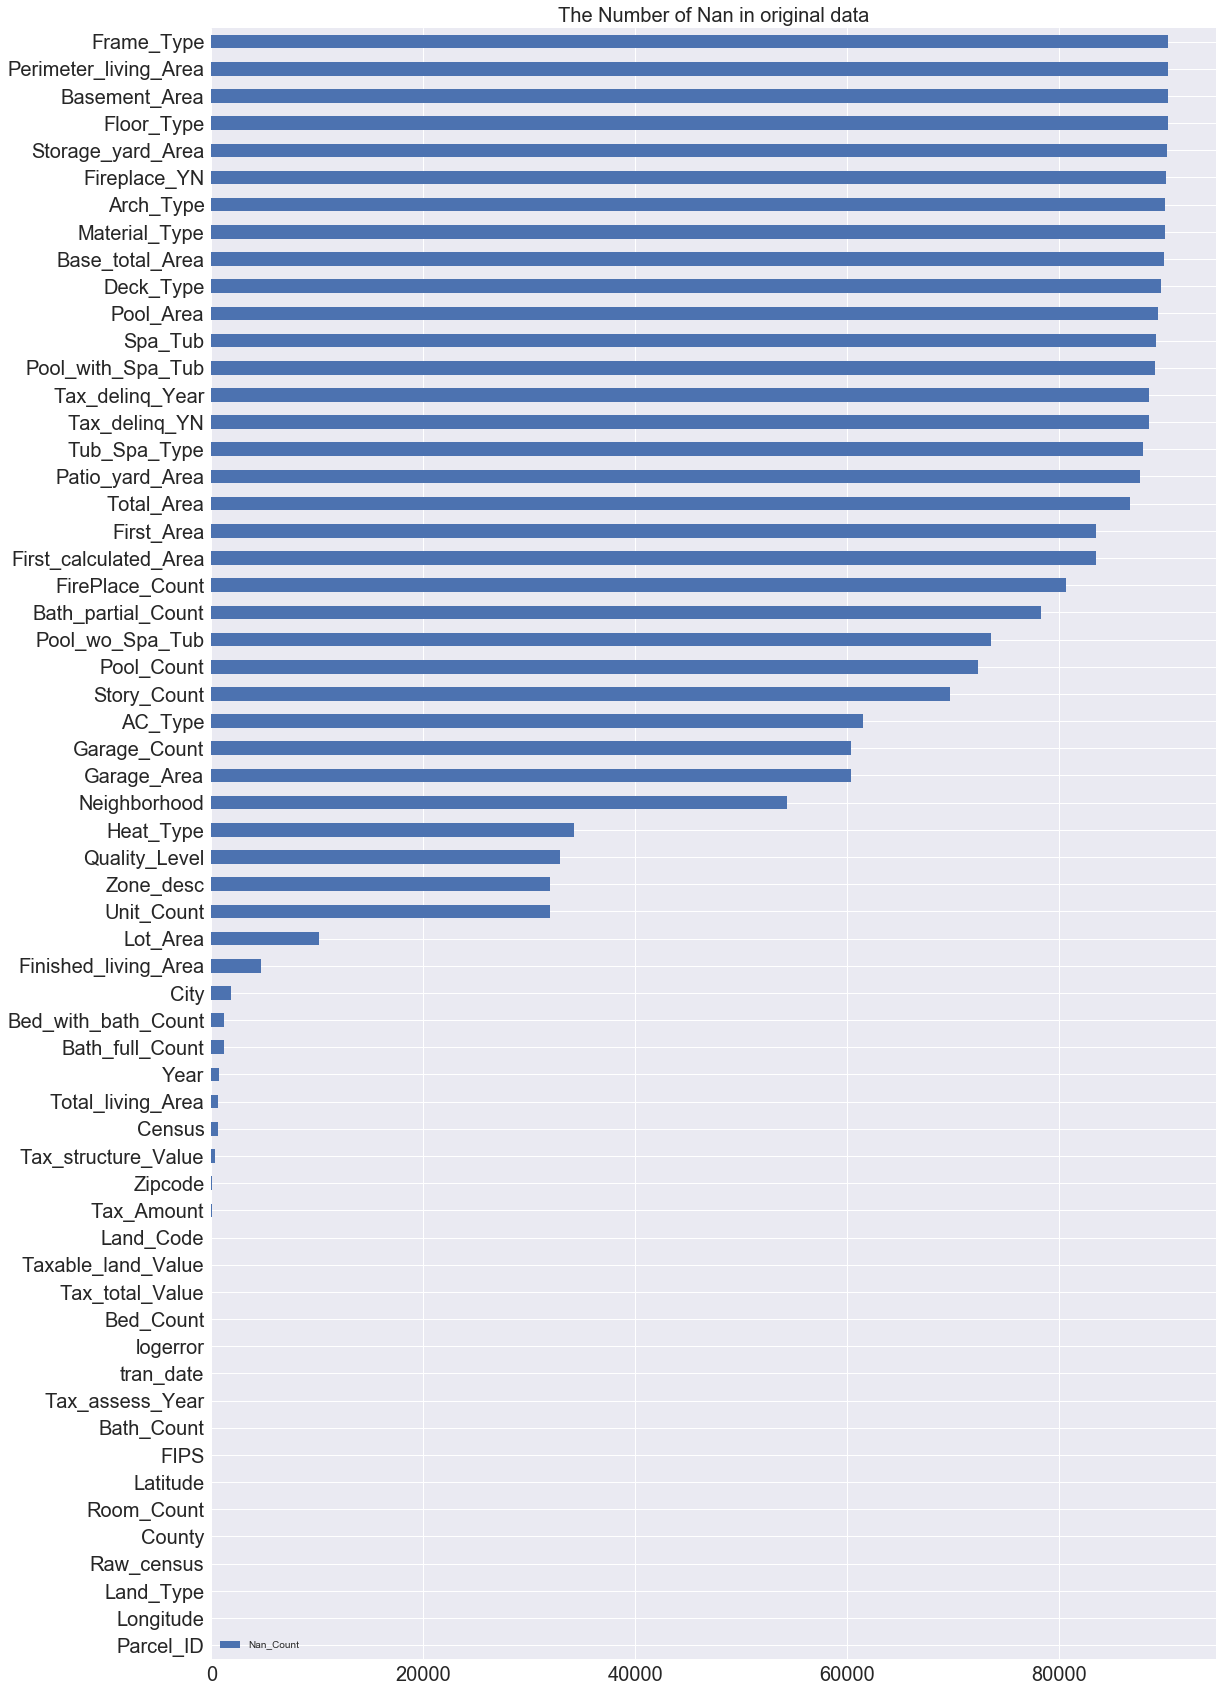

In [5]:
feature_mis = pd.DataFrame(train.isnull().sum().sort_values(),  columns = ["Nan_Count"])

ax = feature_mis.plot.barh(figsize = (18,30),fontsize = 20)
ax.set_title("The Number of Nan in original data", fontsize = 20)

## Tax_delinq_Year

In [6]:
#change year to the exact year, leave nan unchanged
train.Tax_delinq_Year.unique()

array([ nan,  13.,  15.,  12.,  14.,  10.,   9.,   8.,  11.,   7.,   6.,
        99.])

In [7]:
train.Tax_delinq_Year.replace([float(x) for x in range(1,18)],[x for x in range(2001,2018)],inplace = True)

train.Tax_delinq_Year.replace([99.],[1999], inplace = True)

In [8]:
train.Tax_delinq_Year.fillna(-10000, inplace = True)

In [9]:
train.Tax_delinq_Year.unique()

array([-10000.,   2013.,   2015.,   2012.,   2014.,   2010.,   2009.,
         2008.,   2011.,   2007.,   2006.,   1999.])

## Tax_delinq_YN

In [10]:
#"Y" or "N" for delinq
train.Tax_delinq_YN.unique()

array([nan, 'Y'], dtype=object)

In [11]:
train.Tax_delinq_YN.fillna("N", inplace = True)

## Fireplace_YN

In [12]:
train.Fireplace_YN.unique()

array([nan, True], dtype=object)

In [13]:
train.Fireplace_YN.fillna(False, inplace = True)

## Storage_yard_Area

In [14]:
#not sure whether it is reasonalble to change to 0
train.Storage_yard_Area.unique()

array([   nan,  1200.,   126.,   322.,   120.,   235.,   125.,  1197.,
         204.,   156.,    62.,    18.,    55.,   168.,    56.,    54.,
         100.,    36.,   110.,   144.,   264.,   180.,   119.,   252.,
         477.,   150.,   268.,   230.,   231.,   308.,    60.,    34.,
         136.,   864.,   846.,    88.,   159.,  1366.,    37.,    78.,
         642.,   627.,   960.,  1000.,  1182.,   400.,   276.,   290.,
         943.,   192.,   480.,   288.,   108.,    49.,   525.,   408.,
         133.,    96.,    72.,   504.,   310.,   160.,    41.,   104.,
          33.,    90.,    48.,  1050.,   200.,  1100.,   240.,  1248.,
         648.,   550.])

In [15]:
train.Storage_yard_Area.fillna(0, inplace = True)

## Patio_yard_Area

In [16]:
#change to 0
train.Patio_yard_Area.unique()

array([   nan,    54.,   364.,   144.,    77.,   384.,   520.,   247.,
         628.,   984.,   424.,   220.,   180.,    80.,   200.,   389.,
          50.,   276.,   157.,   236.,   300.,   396.,   450.,   973.,
         216.,   150.,    84.,   110.,   420.,    98.,   160.,   210.,
         175.,   242.,   312.,   372.,   208.,   440.,   270.,   400.,
         351.,   307.,   900.,   720.,   129.,   260.,   361.,   325.,
         329.,   120.,   100.,   624.,   456.,   126.,   382.,   598.,
          97.,   136.,   395.,   188.,  1700.,   432.,   273.,   358.,
         843.,   253.,   190.,   104.,   438.,   170.,   109.,   263.,
         192.,   342.,    72.,   310.,   204.,   668.,   262.,   226.,
         529.,   135.,   324.,   427.,   119.,   360.,   474.,   240.,
         219.,  1262.,   535.,   553.,   472.,   492.,   166.,   330.,
         620.,   235.,   254.,   495.,   256.,   308.,    70.,   753.,
         224.,   514.,   292.,   350.,   128.,   317.,   184.,   352.,
      

In [17]:

train.Patio_yard_Area.fillna(0, inplace = True)

## Unit_Count

In [18]:
#do not know how to deal
train.Unit_Count.unique()

array([   1.,   nan,    2.,    4.,    3.,    6.,  143.,   11.,    9.,
          5.,   70.])

In [19]:
train.Unit_Count.fillna(-1, inplace = True)

In [20]:
train["Unit_Count_KU"] = [0 if x == -1 else 1 for x in train.Unit_Count]

## Material_Type

In [23]:
train.Material_Type.unique()

array([ nan,   6.,  13.,   4.])

In [24]:
train.Material_Type.fillna("Unknown", inplace = True)

## Bath_partial_Count

In [25]:
train.Bath_partial_Count.unique()

array([ nan,   1.,   2.,   3.,   4.])

In [26]:
train.Bath_partial_Count.fillna(0, inplace = True)

## Floor_Type

In [27]:
train.Floor_Type.unique()

array([ nan,   7.])

In [28]:
train.Floor_Type.fillna("Unknown", inplace = True)

## Zipcode

In [29]:
#Zipcode is object now
train.Zipcode.unique()

array([  96370.,   96962.,   96293.,   96222.,   96961.,   96109.,
         96091.,   97101.,   96987.,   96963.,   96426.,   96120.,
         96437.,   96947.,   97035.,   96964.,   96393.,   96238.,
         96990.,   96379.,   96239.,   97001.,   97052.,   96026.,
         97050.,   96190.,   97329.,   96349.,   96374.,   96088.,
         96242.,   96008.,   96361.,   96364.,   97007.,   97078.,
         96220.,   97004.,   96295.,   97067.,   96043.,   97048.,
         96387.,   96971.,   96013.,   96505.,   96506.,   96513.,
         97008.,   97041.,   96978.,   96097.,   96133.,   96324.,
         96993.,   96474.,   97026.,   96007.,   96952.,   97116.,
         96447.,   96436.,   97005.,   96384.,   96475.,   96383.,
         96996.,   96986.,   96072.,   96107.,   96965.,   97020.,
         96247.,   97106.,   96995.,   97059.,   96169.,   96028.,
         96020.,   96969.,   96029.,   96351.,   96974.,   97083.,
         96183.,   96957.,   97107.,   96420.,   96193.,   960

In [30]:
#change to unknow 
train.Zipcode = train.Zipcode.fillna(0).astype("int64").astype("object")

## Neighborhood

In [32]:
train.Neighborhood.unique()

array([  31817.,      nan,  275411.,   54300.,   51906.,   19810.,
        273096.,  274961.,   47950.,  276476.,    7877.,  273567.,
         37739.,  416320.,  274359.,   40215.,   40548.,  268509.,
        275738.,  275426.,  118208.,   48570.,  114914.,  762187.,
        275396.,  113455.,  268134.,  403197.,   47880.,   13327.,
        273252.,  274800.,  276606.,  268473.,  276450.,   46736.,
        274828.,   28119.,   27080.,  113749.,  116302.,  274895.,
         13017.,  276157.,  268496.,   27328.,   27484.,  403142.,
        275470.,  275695.,  274750.,  268548.,  118849.,  118872.,
        417224.,  273197.,  268249.,   46795.,  403196.,  268002.,
        116375.,   21056.,  113910.,  276119.,   48200.,  113688.,
        274049.,  115609.,  275496.,  114246.,   32368.,  275994.,
          6952.,  113886.,  403192.,  116774.,  275405.,  268097.,
         41466.,  118825.,   37835.,  275884.,  272968.,  273539.,
        416304.,   34213.,   41131.,  275958.,  268588.,   320

In [33]:
train.Neighborhood.fillna("Unknown",inplace = True)

## County

In [34]:
train.County.unique()

array([ 3101.,  1286.,  2061.])

In [35]:
train.County = train.County.astype("object")

## City

In [36]:
#convert city to object
train.City.unique()

array([  12447.,   32380.,   47019.,   17686.,   29712.,   24174.,
         13150.,   25459.,   46098.,  396054.,   52650.,   17150.,
         25218.,   53655.,   46298.,   34780.,   47568.,   24832.,
          5465.,   40227.,   54311.,   10389.,   21412.,    6395.,
         33252.,   25458.,   24384.,   20008.,   33836.,    8384.,
         24812.,   53571.,   51617.,   45888.,   45457.,   15554.,
         24245.,   16764.,   27110.,   40081.,   41673.,   34278.,
         12773.,   16389.,   42150.,   54970.,      nan,   52842.,
         34543.,   15237.,   53636.,   37688.,   13693.,    5534.,
         54722.,   50749.,   51239.,   27491.,  118225.,   27103.,
         13091.,   33837.,   50677.,   10608.,   10723.,   48424.,
         47762.,    6021.,    9840.,   18874.,   38032.,   44833.,
         24435.,   12292.,   10774.,   37015.,  396556.,   45602.,
         33311.,   33612.,   44116.,   10241.,   25974.,   21778.,
         14634.,   11626.,   40009.,   14542.,   30187.,   329

In [37]:
train.City.fillna("Unknown",inplace = True)

## Raw_ceusus

In [39]:
#Census tract and block ID combined - also contains blockgroup assignment by extension. Hard to group
#convert to object
Counter(train.Raw_census)
train.Raw_census.isnull().sum() #no missing value. 

0

In [40]:
train.Raw_census = train.Raw_census.astype("object")

## Zone_desc

In [41]:
train.Zone_desc.unique()

array(['LARS', nan, 'PSR6', ..., 'SHCG', 'COR2YY', 'LNR2RPD-R3'], dtype=object)

In [42]:
train.Zone_desc.isnull().sum()

31962

In [43]:
train.Zone_desc.fillna("Unknown", inplace = True)

## Land_Type

In [44]:
#convert Land_Type to object
train.Land_Type.unique()

array([ 261.,  266.,  265.,  246.,  263.,  269.,  248.,  247.,  267.,
        275.,  260.,   31.,  264.,   47.])

In [45]:
train.Land_Type = train.Land_Type.astype("object")

## Spa_Tub

In [47]:
#0 or 1 for F and T
train.Spa_Tub.unique()

array([ nan,   1.])

In [48]:
train.Spa_Tub.fillna(0, inplace = True)

## Pool_with_Spa_Tub

In [49]:
train.Pool_with_Spa_Tub.unique()

array([ nan,   1.])

In [50]:
train.Pool_with_Spa_Tub.fillna(0, inplace = True)

## Pool_wo_Spa_Tub

In [51]:
train.Pool_wo_Spa_Tub.unique()

array([ nan,   1.])

In [52]:
train.Pool_wo_Spa_Tub.fillna(0, inplace = True)

## Land_Code

In [53]:
train.Land_Code.unique()

array(['0100', '1', '010C', '122', '1129', '34', '1128', '010E', '0104',
       '0101', '0200', '0700', '1111', '01DC', '010D', '1110', '0400',
       '012C', '010V', '1116', '01HC', '010G', '0300', '010F', '1117',
       '0103', '38', '1210', '0111', '010M', '96', '135', '0108', '1014',
       '1112', '0201', '0109', '1310', '010H', '1410', '1222', '1321',
       '1720', '1011', '1432', '0401', '0102', '012D', '73', '105', '0110',
       '100V', '0130', '8800', '0303', '0210', '1012', '1333', '0114',
       '01DD', '020G', '040A', '012E', '020M', '040V', '070D', '1200',
       '030G', '1722', '6050', '1421', '010', nan, '200', '0', '1420',
       '0131', '0301'], dtype=object)

In [54]:
train.Land_Code.fillna("Unknown", inplace = True)

## Heat_Type

In [55]:
#heat type instead of number. so change to object feature
train.Heat_Type.unique()

array([  2.,  nan,   7.,   6.,  24.,  13.,  20.,  18.,  11.,   1.,  14.,
        12.,  10.])

In [56]:
train.Heat_Type.fillna("Unknown",inplace = True)

## AC_Type

In [57]:
train.AC_Type.unique()

array([  1.,  nan,   5.,  13.,  11.,   9.,   3.])

In [58]:
train.AC_Type.fillna("Unknown", inplace = True)

## Arch_Type

In [59]:
train.Arch_Type.unique()

array([ nan,   7.,   8.,   2.,  10.,   3.,  21.])

In [60]:
train.Arch_Type.fillna("Unknown", inplace = True)

## Basement_Area

In [61]:
#replace nan with float 0, assume it does  not have basement
train.Basement_Area.unique()

array([   nan,   814.,   330.,   168.,   671.,  1555.,  1528.,   771.,
         700.,   831.,  1048.,  1312.,   690.,   564.,   198.,   676.,
         184.,   540.,   260.,   557.,   312.,   913.,  1350.,   802.,
         162.,   616.,  1551.,   485.,   238.,   493.,   760.,   515.,
         196.,   585.,   234.,   510.,   579.,   100.,   608.,  1210.])

In [62]:
train.Basement_Area.fillna(0, inplace = True)

## Frame_Type

In [63]:
train.Frame_Type.unique()

array([ nan,   4.])

In [64]:
train.Frame_Type.fillna("Unknown", inplace = True)

## Quality_Level

In [65]:
train.Quality_Level.unique() 
#this needs to be a numerical feature, leave nan as it is

array([  4.,  nan,   1.,   7.,  12.,  10.,   8.,   6.,  11.])

In [66]:
train.Quality_Level.fillna(-1, inplace = True)

In [67]:
train["Quality_Level_KU"] = [0 if x == -1 else 1 for x in train.Quality_Level]

## Bed_with_bath_Count

In [68]:
train.Bed_with_bath_Count.unique()
#leave nan as it is

array([  2. ,   3.5,   3. ,   2.5,   4. ,   1. ,   5. ,   5.5,   1.5,
         8. ,   nan,   4.5,   9. ,   7. ,   6. ,  10. ,   6.5,   7.5,
        12. ,  11. ,  20. ,   8.5,  15. ])

In [69]:
train.Bed_with_bath_Count.fillna(0, inplace = True)

## Deck_Type

In [70]:
train.Deck_Type.unique()

array([ nan,  66.])

In [71]:
train.Deck_Type.fillna("Unknown",inplace = True)

## First_calculated_Area

In [72]:
#TWo columns are the same, drop one
train.First_calculated_Area.unique()

array([   nan,   853.,   981., ...,   819.,  2288.,  1774.])

In [73]:
train.First_Area.unique()

array([   nan,   853.,   981., ...,   819.,  2288.,  1774.])

In [74]:
train = train.drop("First_calculated_Area", axis = 1, errors = False)

In [75]:
train = train.drop("First_Area", axis = 1, errors = False)

## Perimeter_living_Area

In [76]:
train.Perimeter_living_Area.unique()

array([   nan,  1392.,  1440.,  1536.,  1344.,  1566.,  1464.,  1152.,
        1584.,  1248.,  1416.,  1056.])

In [77]:
train.Perimeter_living_Area.isnull().sum()

90242

In [78]:
train = train.drop("Perimeter_living_Area", axis = 1, errors = False)

## FIPS

In [79]:
train.FIPS.unique()

array([ 6037.,  6059.,  6111.])

In [80]:
#convert FIPS to object, since it only contains 3 kinds of codes federal use
train.FIPS = train.FIPS.astype('object')

## FirePlace_Count

In [81]:
train.FirePlace_Count.unique()

array([ nan,   1.,   2.,   3.,   4.,   5.])

In [82]:
#fill na with 0
train.FirePlace_Count.fillna(0, inplace = True)

## Bath_full_Count

In [83]:
train.Bath_full_Count.unique()

array([  2.,   3.,   4.,   1.,   5.,   8.,  nan,   9.,   7.,   6.,  10.,
        12.,  11.,  20.,  15.])

In [84]:
train.Bath_full_Count.fillna(0, inplace = True)

## Garage_Count

In [85]:
train.Garage_Count.unique()

array([ nan,   2.,   1.,   3.,   0.,   4.,   6.,   8.,   5.,   7.,  11.,
        10.,  24.,   9.,  13.,  14.])

In [86]:
train.Garage_Count.fillna(0, inplace = True)

## Garage_Area

In [87]:
train.Garage_Area.unique()

array([   nan,   468.,   598.,     0.,   400.,   471.,   462.,   437.,
         441.,   401.,   775.,   380.,   440.,   482.,   595.,   753.,
         350.,   360.,   300.,   546.,   453.,   600.,   339.,   630.,
         683.,   438.,   420.,   495.,   216.,   483.,   454.,   436.,
         571.,   450.,   548.,   651.,   385.,   636.,   481.,  1025.,
         460.,   609.,   452.,   761.,   451.,   585.,   666.,  1048.,
         264.,   988.,   926.,   827.,   690.,   648.,   461.,   413.,
         500.,   410.,   409.,   480.,   470.,   672.,   687.,   494.,
         619.,   608.,   435.,   180.,   620.,   444.,   457.,   455.,
         399.,   498.,   472.,   242.,   474.,   662.,   370.,   518.,
         458.,   708.,   345.,   824.,   484.,   746.,   442.,   539.,
         448.,   615.,   456.,   430.,   504.,   617.,   358.,   580.,
         449.,   445.,   596.,   660.,   638.,   625.,   464.,   336.,
         426.,   234.,   473.,   491.,   631.,   499.,   670.,   384.,
      

In [88]:
train.Garage_Area.fillna(0, inplace = True)

## Tub_Spa_Type

In [89]:
train.Tub_Spa_Type.unique()

array([nan, True], dtype=object)

In [90]:
train.Tub_Spa_Type.fillna(False, inplace = True)

## Base_total_Area

In [91]:
train.Base_total_Area.isnull().sum()

89854

In [92]:
train.Base_total_Area.fillna(0, inplace = True)

## Pool_Area

In [93]:
train.Pool_Area.isnull().sum()

89306

In [94]:
train.Pool_Area.fillna(0, inplace = True)

## Total_Area

In [95]:
train.Total_Area.isnull().sum()

86711

In [96]:
train.Total_Area.fillna(0, inplace = True)

## Pool_Count

In [97]:
train.Pool_Count.isnull().sum()

72374

In [98]:
train.Pool_Count.unique()

array([ nan,   1.])

In [99]:
train.Pool_Count.fillna(0, inplace = True)

## Story_Count

In [100]:
train.Story_Count.isnull().sum()

69705

In [101]:
train.Story_Count.unique()

array([ nan,   2.,   1.,   3.,   4.])

In [102]:
train.Story_Count.fillna(-1, inplace = True)

In [103]:
train["Story_Count_KU"] = [0 if x == -1 else 1 for x in train.Story_Count]

## Lot_Area

In [104]:
train.Lot_Area.unique()

array([   7528.,    3643.,   11423., ...,   35223.,   50431.,  156910.])

In [105]:
train.Lot_Area.isnull().sum()

10150

In [106]:
train.Lot_Area.fillna(-1, inplace = True)

In [107]:
train["Lot_Area_KU"] = [0 if x == -1 else 1 for x in train.Lot_Area]

## Finished_living_Area

In [108]:
train.Finished_living_Area.unique()

array([  1684.,   2263.,   2217., ...,   3758.,  10681.,  10014.])

In [109]:
fm = np.mean(train.Finished_living_Area)

In [110]:
train.Finished_living_Area.fillna(fm, inplace = True)

## Census

In [111]:
train.Census.unique()

array([  6.03710665e+13,              nan,   6.03746380e+13, ...,
         6.03722831e+13,   6.03719900e+13,   6.03757300e+13])

In [112]:
train.Census = train.Census.astype("object")

In [113]:
train.Census.fillna("Unknown", inplace = True)

## Year

In [114]:
#replace by mean
train.Year.fillna(np.mean(train.Year), inplace = True)

## Total_living_Area

In [115]:
train.Total_living_Area.fillna(np.mean(train.Total_living_Area), inplace = True)

## Tax_structure_Value

In [116]:
train.Tax_structure_Value.fillna(np.mean(train.Tax_structure_Value), inplace = True)

## Tax_Amount

In [117]:
train.Tax_Amount.fillna(np.mean(train.Tax_Amount), inplace = True)

## Taxable_land_Value

In [118]:
train.Taxable_land_Value.fillna(np.mean(train.Taxable_land_Value), inplace = True)

## Tax_total_Value

In [119]:
train.Tax_total_Value.fillna(np.mean(train.Tax_total_Value), inplace = True)

## Recheck the dtypes and missing values in all the columns

In [120]:
#numerical variable include
num_v1 = train.select_dtypes(include = ['float64','int64']).columns
print num_v1
print len(num_v1)

Index([u'Parcel_ID', u'logerror', u'Basement_Area', u'Bath_Count',
       u'Bed_Count', u'Quality_Level', u'Bed_with_bath_Count',
       u'Total_living_Area', u'Finished_living_Area', u'Total_Area',
       u'Base_total_Area', u'FirePlace_Count', u'Bath_full_Count',
       u'Garage_Count', u'Garage_Area', u'Latitude', u'Longitude', u'Lot_Area',
       u'Pool_Count', u'Pool_Area', u'Spa_Tub', u'Pool_with_Spa_Tub',
       u'Pool_wo_Spa_Tub', u'Room_Count', u'Bath_partial_Count', u'Unit_Count',
       u'Patio_yard_Area', u'Storage_yard_Area', u'Year', u'Story_Count',
       u'Tax_structure_Value', u'Tax_total_Value', u'Tax_assess_Year',
       u'Taxable_land_Value', u'Tax_Amount', u'Tax_delinq_Year',
       u'Unit_Count_KU', u'Quality_Level_KU', u'Story_Count_KU',
       u'Lot_Area_KU'],
      dtype='object')
40


In [121]:
obj_v1 = train.select_dtypes(include = ['object']).columns
print obj_v1
print len(obj_v1)

Index([u'tran_date', u'AC_Type', u'Arch_Type', u'Frame_Type', u'Deck_Type',
       u'FIPS', u'Heat_Type', u'Land_Code', u'Land_Type', u'Zone_desc',
       u'Raw_census', u'City', u'County', u'Neighborhood', u'Zipcode',
       u'Floor_Type', u'Material_Type', u'Tax_delinq_YN', u'Census'],
      dtype='object')
19


In [122]:
feature_mis = pd.DataFrame(train.isnull().sum().sort_values(),  columns = ["Nan_Count"])
#ax = feature_mis.plot.barh(figsize = (18,30),fontsize = 20)
#ax.set_title("The Number of Nan in processed data", fontsize = 20)
#ax.legend("Nan_Count", fontsize = 25)

In [123]:
feature_mis.Nan_Count.sort_values() #all zeros

Parcel_ID               0
logerror                0
tran_date               0
AC_Type                 0
Arch_Type               0
Basement_Area           0
Bath_Count              0
Bed_Count               0
Frame_Type              0
Quality_Level           0
Bed_with_bath_Count     0
Deck_Type               0
Total_living_Area       0
Finished_living_Area    0
Total_Area              0
Base_total_Area         0
FIPS                    0
FirePlace_Count         0
Bath_full_Count         0
Garage_Count            0
Garage_Area             0
Tub_Spa_Type            0
Heat_Type               0
Latitude                0
Longitude               0
Lot_Area                0
Pool_Count              0
Pool_Area               0
Spa_Tub                 0
Pool_with_Spa_Tub       0
                       ..
Land_Code               0
Land_Type               0
Zone_desc               0
Raw_census              0
City                    0
County                  0
Neighborhood            0
Zipcode     

In [124]:
train.to_csv("train_V2.csv")

In [125]:
train.head()

,Parcel_ID,logerror,tran_date,AC_Type,Arch_Type,Basement_Area,Bath_Count,Bed_Count,Frame_Type,Quality_Level,...,Tax_assess_Year,Taxable_land_Value,Tax_Amount,Tax_delinq_YN,Tax_delinq_Year,Census,Unit_Count_KU,Quality_Level_KU,Story_Count_KU,Lot_Area_KU
0,11016594,0.0276,2016-01-01,1,Unknown,0.0,2.0,3.0,Unknown,4.0,...,2015.0,237416.0,6735.88,N,-10000.0,6.03711e+13,1,1,0,1
1,14366692,-0.1684,2016-01-01,Unknown,Unknown,0.0,3.5,4.0,Unknown,-1.0,...,2015.0,239071.0,10153.02,N,-10000.0,Unknown,0,0,0,1
2,12098116,-0.0040,2016-01-01,1,Unknown,0.0,3.0,2.0,Unknown,4.0,...,2015.0,57912.0,11484.48,N,-10000.0,6.03746e+13,1,1,0,1
3,12643413,0.0218,2016-01-02,1,Unknown,0.0,2.0,2.0,Unknown,4.0,...,2015.0,73362.0,3048.74,N,-10000.0,6.0373e+13,1,1,0,1
4,14432541,-0.0050,2016-01-02,Unknown,Unknown,0.0,2.5,4.0,Unknown,-1.0,...,2015.0,264977.0,5488.96,N,-10000.0,6.05904e+13,0,0,1,1
